## Run ANL's LOM, PILOWF, for Height analysis

Jenna Ruzekowicz (jenna.ruzekowicz@nrel.gov), Caleb Phillips (caleb.phillips@nrel.gov), and Dmitry Duplyakin (dmitry.duplyakin@nrel.gov)

The purpose of this notebook is to read in inflow data, load obstacle data, and run the LOMs.

Output is saved into files named:

 > `bergey|oneenergy_anl|lanl_tid_windSource_obstacleMode.csv.bz2`, 
 
 > where `windSource` is one of: `wtk`, `wtk_led_2018`, `wtk_led_2019`, `wtk_bc`, `wtk_led_bc` (`bc` referes to bias corrected versions) 
 
 > and `obstacleMode` is one of: `bldgsonly`, `treesasbldgs`, `bldgsandtrees`

### Work notes:

- Currently only ANL model
- Sites t007 and t074 are currently excluded becuase they don't have height data matching other sites
- Code looks for `"%s/%sv2.json" % (obstacle_data_dir, tid)` files for site obstacles inside `02 Input For Models` dir
- Sites t207 take a very long time! (slowest site)
- Notice that based on the plots at the end of the notebook ws-adjusted = ws (exactly) for quite a few sites. No negative ws-adjusted values observed yet for this set of inputs.
- `wind_sources = ["wtk", "wtk_led_2019", "wtk_bc", "wtk_led_bc"]` -- not including "wtk_led_2018" yet becuase 5-minuted data for 2018 is very large and processing will be slower than for other options here; will add it for final/more complete processing
- `overwrite` (if not set) flag allows to skip processing previously studied site x wind_source combinations (if output files with matching names are found)

### Site selection (suggested by Caleb):

- t140 (on rural/suburban boundary)
- t182 (rural/suburban boundary)
- t028 (suburban)
- t169 (urban/suburban)
- t221 (urban/suburban)
- t207 (urban/suburban). 
- smaller subsetwith the three “urban/suburban” ones as they are presumably the most challenging cases (169, 221 and 207)

In [30]:
import numpy as np
import pandas as pd
import geopandas as gpd
from tqdm import tqdm
import matplotlib.pyplot as plt
from dw_tap.lom import run_lom
import os
import seaborn as sns
import glob
from dw_tap.data_processing import _LatLon_To_XY, filter_obstacles
import subprocess
import shutil

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [31]:
index = pd.read_csv("01 Bergey Turbine Data/bergey_sites.csv")
index.head()

,APRS ID,AID,Public Site Name,Internal Site Name,State,Latitude,Longitude,Hub Height (m),Lidar Quality,Lidar Collection Year,...,Building Data Quality,Turbine,Periods with Consistent Generation Data,Met Tower,Met Tower Latitude,Met Tower Longitude,Measurement Height (m),Measurement Privacy,Bergey Annual Average Wind Speed (m/s),Bergey Generation (kWh) (0% Loss Assumption)
0,t007,A2744,Fremont,Fremont,MN,43.918622,-91.899498,41,N/A (Legacy Data),NaN,...,"Partial, some missing",Bergey Excel 10,2012/01 - 2013/12 (outage starting mid-2013/11...,mn_prairiestar.PROPRIETARY.pruf.csv,43.673,-92.698,50.0,Proprietary,6.55,24828
1,t024,A2690,Washoe,Thomas Danzinger,NV,39.331088,-119.820230,30,QL1,2020.0,...,Good coverage,Bergey Excel 10,2011/01 - 2022/12,NaN,NaN,NaN,NaN,NaN,5.86,19184
2,t028,A2672,Towamensing,Derr,PA,40.851353,-75.598395,30,QL2,2019.0,...,"Partial, some missing",Bergey Excel 10,2011/01 - 2022/12,NaN,NaN,NaN,NaN,NaN,4.60,9670
3,t034,A3685,Lycoming,Dan Poor,NY,43.524158,-76.372290,31,QL2,2018.0,...,Good coverage,Bergey Excel 10,"2013/01 - 2017/12, 2019/01 - 2021/12",ny_oswego.qc.csv,43.464,-76.511,15.0,Public,6.55,24828
4,t041,A3933,Rockford,Fossil Park,IA,43.047418,-92.981674,37,QL2,2020.0,...,Good coverage,Bergey Excel 10,"2013/01 - 2013/12, 2015/01 - 2022/12",NaN,NaN,NaN,NaN,NaN,5.94,19829


### Select which sites need to be processed, wind data sources, and obstacles modes

In [163]:
# Small test with several sites
selected = ["t169"] #["t182", "t140", "t169", "t221", "t207"] # ["t028"] # "t182", "t140", "t169", "t221", "t207"]

# Process all sites:
#selected = index["APRS ID"].tolist()

# Remove 2 sites that currently don't have obstacle descriptions with the heights based on lidar data
#selected = [x for x in selected if not(x in ["t007", "t074"])]

# Remove slowest site for now
#selected = [x for x in selected if not(x in ["t207"])]
print(selected)

wind_sources = ["wtk_rh_analysis"] # Choices here: "wtk", "wtk_led_2018", "wtk_led_2019", "wtk_bc"

obstacle_modes = ["bldgsonly_100m"] #["bldgsonly", "bldgsonly_100m"]

['t169']


### Load wind data

In [164]:
atmospheric_inputs = {}

for wind_source in wind_sources:

    if wind_source == "wtk_rh_analysis":

        wtk_df = pd.read_csv("01 Bergey RH_analysis/wtk.csv.bz2")

        # Create dict with dataframes that correspond to selected tid's
        dfs_by_tid = {}
        for tid in selected:
            tid_subset = wtk_df[wtk_df["tid"] == tid]
            
            dfs_by_height = {}
            for height in tid_subset.height.unique():
                dfs_by_height[height] = tid_subset[tid_subset["height"] == height].reset_index(drop=True)
            
            dfs_by_tid[tid] = dfs_by_height
        
        atmospheric_inputs[wind_source] = dfs_by_tid
        
    else:
        print("Unsupported wind_source selected:", wind_source)

In [165]:
# Example input

atmospheric_inputs["wtk_rh_analysis"]["t169"][80]

,datetime,ws,wd,tid,height,packet_date
0,2007-01-01 00:00:00,11.795748,208.865071,t169,80,2007-01-01 00:00:00+00:00
1,2007-01-01 01:00:00,10.905802,211.272405,t169,80,2007-01-01 01:00:00+00:00
2,2007-01-01 02:00:00,11.185390,218.813427,t169,80,2007-01-01 02:00:00+00:00
3,2007-01-01 03:00:00,11.877925,225.873202,t169,80,2007-01-01 03:00:00+00:00
4,2007-01-01 04:00:00,11.733025,222.038915,t169,80,2007-01-01 04:00:00+00:00
...,...,...,...,...,...,...
8756,2007-12-31 20:00:00,2.515717,157.267556,t169,80,2007-12-31 20:00:00+00:00
8757,2007-12-31 21:00:00,4.149601,154.890737,t169,80,2007-12-31 21:00:00+00:00
8758,2007-12-31 22:00:00,4.309583,131.358222,t169,80,2007-12-31 22:00:00+00:00
8759,2007-12-31 23:00:00,5.590305,118.073695,t169,80,2007-12-31 23:00:00+00:00


In [166]:
# Input height for a given tid:

sorted(atmospheric_inputs["wtk_rh_analysis"]["t169"].keys())

[37, 40, 50, 60, 70, 80]

### Load obstacle data

In [167]:
sites_with_tall_blgs = [] 

obstacle_inputs = {}
for tid in selected:
    #print("Processing tid: ", tid)
    
    index_row = index[index["APRS ID"] == tid].iloc[0]
    z_turbine = index_row["Hub Height (m)"]
    
    obstacle_data_dir = "01 Bergey Turbine Data/3dbuildings_geojson"
    obstacle_data_file = "%s/%sv2.json" % (obstacle_data_dir, tid)
    
    if os.path.exists(obstacle_data_file):
        #print("BEFORE filtering (%s):" % obstacle_data_file)
        #display(gpd.read_file(obstacle_data_file))
        
        obstacle_df = filter_obstacles(tid,
                                       gpd.read_file(obstacle_data_file), 
                                       include_trees=False,                    # No trees for this analysis!
                                       turbine_height_for_checking=z_turbine)
        obstacle_df["tid"] = tid
        obstacle_inputs[tid] = obstacle_df
        
        #print("AFTER filtering (%s):" % obstacle_data_file)
        #display(obstacle_df)
    else:
        print("Can't access: %s. Skipping" % obstacle_data_file)

all_obstacle_inputs = pd.concat(obstacle_inputs.values())
display(all_obstacle_inputs)

/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/dw_tap-0.0.1-py3.8.egg/dw_tap/data_processing.py:327: UserWarning: (tid: t169) Detected at least 1 obstacle that is as tall as the studied turbine:
        height feature_type                                           geometry
1    47.690002     building  POLYGON ((-85.12322 41.07841, -85.12321 41.078...
4    38.265015     building  POLYGON ((-85.12048 41.07932, -85.12047 41.079...
5    37.169983     building  POLYGON ((-85.11821 41.07941, -85.11821 41.079...
20   40.309998     building  POLYGON ((-85.11423 41.07398, -85.11421 41.073...
174  59.519958     building  POLYGON ((-85.11854 41.07733, -85.11854 41.077...
176  43.849976     building  POLYGON ((-85.11506 41.07897, -85.11524 41.078...
177  43.159973     building  POLYGON ((-85.11557 41.07895, -85.11575 41.078...
600  40.349976     building  POLYGON ((-85.11578 41.07669, -85.11577 41.076...
  warnings.warn("(tid: %s) Detected at least 1 obstacle that is as tall as 

,height,geometry,feature_type,tid
0,32.950012,"POLYGON ((-85.11634 41.07768, -85.11633 41.078...",building,t169
1,47.690002,"POLYGON ((-85.12322 41.07841, -85.12321 41.078...",building,t169
2,32.080017,"POLYGON ((-85.12189 41.07936, -85.12207 41.079...",building,t169
3,32.325012,"POLYGON ((-85.12095 41.07940, -85.12115 41.079...",building,t169
4,38.265015,"POLYGON ((-85.12048 41.07932, -85.12047 41.079...",building,t169
...,...,...,...,...
596,23.030029,"POLYGON ((-85.11109 41.07730, -85.11109 41.077...",building,t169
597,9.675018,"POLYGON ((-85.11139 41.07749, -85.11139 41.077...",building,t169
598,17.575012,"POLYGON ((-85.11101 41.07748, -85.11114 41.077...",building,t169
599,17.579956,"POLYGON ((-85.11102 41.07758, -85.11113 41.077...",building,t169


In [168]:
# Save combined and filtered obstacles dataframe into a file
#obstacle_data_dir = "01 Bergey Turbine Data/3dbuildings_geojson"
#dest_file = "%s/all_obstacles.json" % (obstacle_data_dir)
#all_obstacle_inputs.to_file(dest_file, driver="GeoJSON", index=False)

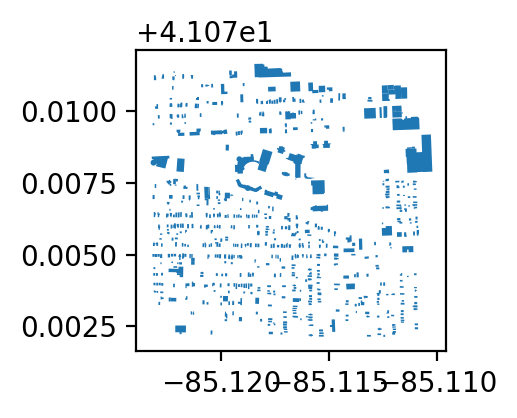

In [169]:
# Quick vis:
for tid, obstacle_df in obstacle_inputs.items():
    obstacle_df.plot(figsize=(2,2))

### Run PILOF for different H values

In [170]:
# Prepare files for PILOWF + multiprocessing & run LOM

# This flag allows overwriting previously saved files with results if they are found in the specified directory dest_dir 
overwrite = True

# Will be used in the filenames
site_type = "bergey"

# Will be used in the filenames
model_type = "anl"

dest_dir = "01 Bergey Turbine Data/pilowf_inputs_h_analysis/"

script_path = "./run_pilowf_mp.py"

output_dest = "03 Model Outputs/h_analysis"
if not os.path.exists(output_dest):
    os.makedirs(output_dest)    

for obstacle_mode in obstacle_modes:
    for wind_source in wind_sources: 

        for tid in selected:
            
            row = index[index["APRS ID"] == tid].iloc[0]
            lat = row["Latitude"]
            lon = row["Longitude"]
            xy_turbine = [np.array([lon, lat])]
            
            heights = sorted(atmospheric_inputs["wtk_rh_analysis"][tid].keys())
            for height in heights:
                
                # Make sure to start from scratch and not reuse previously saved inputs for models
                if os.path.exists(dest_dir):
                    shutil.rmtree(dest_dir, ignore_errors=True)
                os.makedirs(dest_dir)   
                
                #tid_height_label= "%s%s" % (tid, heights)
                
                print("obstacle_mode=%s, wind_source=%s, tid=%s, height=%d" % (obstacle_mode, wind_source, tid, height))
            
                # Assume trees pass the filtering run above in this notebook 
                obs_df = obstacle_inputs[tid].copy()

                if obstacle_mode == "bldgsonly":
                    obs_df = obs_df[obs_df["feature_type"] == "building"].reset_index(drop=True)
                elif obstacle_mode == "bldgsonly_100m":
                    # Assume trees pass the filtering run above in this notebook 
                      
                    print("# of obs (before 100m filtering):", len(obs_df))
                    obs_df = filter_obstacles(tid,
                                              obs_df,
                                              include_trees=False, 
                                              turbine_height_for_checking=z_turbine,
                                              limit_to_radius_in_m=100.0,
                                              turbine_lat_lon=(lat, lon))
                    print("# of obs (after 100m filtering):", len(obs_df))

                if len(obs_df) == 0:
                    print("tid=%s: Obstacle set is empty after filtering. ws-adjusted=ws for this cases." % tid)
                    output_dest = "%s/%s_%s_%s_%s_%s_%s.csv.bz2" % (output_dest, site_type, model_type, tid, wind_source, obstacle_mode, height)

                    if (not overwrite) and (os.path.exists(output_dest)):
                        print("Found previously saved %s); overwrite flag is off. Skipping to next config." % (output_dest))
                    else:
                        res = atmospheric_inputs[wind_source][tid][height].copy()
                        res["ws-adjusted"] = res["ws"]
                        res.to_csv(output_dest, index=False)  
                        print("Saved output:", output_dest)

                    # Skip the following and go to the next tid x obstacle_mode combination
                    continue

                # Save inputs for PILOWF into separate files
                obs_df.to_file("%s/%s-obstacles.json" % (dest_dir, tid),\
                               driver="GeoJSON", index=False)
                atmospheric_inputs[wind_source][tid][height].to_csv("%s/%s-atmospheric.csv.bz2" % (dest_dir, tid), index=False)

                # It is expecteed that inputs_dir now has a set of individual inputs (atmosperic file and obstacle file for each tid)

                # Must use subprocess as a way of wrapping/calling the python script becuase that script uses multiprocessing
                # and other methods seem to break
                # "<TID>" in "--output_filename_pattern" will replaces with actual TIDs inside the script with parallel processing

                subprocess.run(["python", script_path,
                            "--inputs_dir", dest_dir, \
                            "--index_file", "01 Bergey Turbine Data/bergey_sites.csv", \
                            "--output_filename_pattern", \
                                "%s/%s_%s_%s_%s_%s_%s.csv.bz2" % (output_dest, site_type, model_type, "<TID>", wind_source, obstacle_mode, height), \
                            "--procs", "8"],
                           #stdout=subprocess.DEVNULL, # This addition suppresses entire (lengthy) output
                           cwd="./")

obstacle_mode=bldgsonly_100m, wind_source=wtk_rh_analysis, tid=t169, height=37
# of obs (before 100m filtering): 601
# of obs (after 100m filtering): 5


/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/dw_tap-0.0.1-py3.8.egg/dw_tap/data_processing.py:327: UserWarning: (tid: t169) Detected at least 1 obstacle that is as tall as the studied turbine:
        height feature_type                                           geometry
1    47.690002     building  POLYGON ((-85.12322 41.07841, -85.12321 41.078...
4    38.265015     building  POLYGON ((-85.12048 41.07932, -85.12047 41.079...
5    37.169983     building  POLYGON ((-85.11821 41.07941, -85.11821 41.079...
20   40.309998     building  POLYGON ((-85.11423 41.07398, -85.11421 41.073...
174  59.519958     building  POLYGON ((-85.11854 41.07733, -85.11854 41.077...
176  43.849976     building  POLYGON ((-85.11506 41.07897, -85.11524 41.078...
177  43.159973     building  POLYGON ((-85.11557 41.07895, -85.11575 41.078...
600  40.349976     building  POLYGON ((-85.11578 41.07669, -85.11577 41.076...
  warnings.warn("(tid: %s) Detected at least 1 obstacle that is as tall as 

Done with loading ML model.


Runtime: 10.86 (s)
obstacle_mode=bldgsonly_100m, wind_source=wtk_rh_analysis, tid=t169, height=40
# of obs (before 100m filtering): 601
# of obs (after 100m filtering): 5


/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/dw_tap-0.0.1-py3.8.egg/dw_tap/data_processing.py:327: UserWarning: (tid: t169) Detected at least 1 obstacle that is as tall as the studied turbine:
        height feature_type                                           geometry
1    47.690002     building  POLYGON ((-85.12322 41.07841, -85.12321 41.078...
4    38.265015     building  POLYGON ((-85.12048 41.07932, -85.12047 41.079...
5    37.169983     building  POLYGON ((-85.11821 41.07941, -85.11821 41.079...
20   40.309998     building  POLYGON ((-85.11423 41.07398, -85.11421 41.073...
174  59.519958     building  POLYGON ((-85.11854 41.07733, -85.11854 41.077...
176  43.849976     building  POLYGON ((-85.11506 41.07897, -85.11524 41.078...
177  43.159973     building  POLYGON ((-85.11557 41.07895, -85.11575 41.078...
600  40.349976     building  POLYGON ((-85.11578 41.07669, -85.11577 41.076...
  warnings.warn("(tid: %s) Detected at least 1 obstacle that is as tall as 

Done with loading ML model.


Runtime: 11.17 (s)
obstacle_mode=bldgsonly_100m, wind_source=wtk_rh_analysis, tid=t169, height=50
# of obs (before 100m filtering): 601
# of obs (after 100m filtering): 5


/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/dw_tap-0.0.1-py3.8.egg/dw_tap/data_processing.py:327: UserWarning: (tid: t169) Detected at least 1 obstacle that is as tall as the studied turbine:
        height feature_type                                           geometry
1    47.690002     building  POLYGON ((-85.12322 41.07841, -85.12321 41.078...
4    38.265015     building  POLYGON ((-85.12048 41.07932, -85.12047 41.079...
5    37.169983     building  POLYGON ((-85.11821 41.07941, -85.11821 41.079...
20   40.309998     building  POLYGON ((-85.11423 41.07398, -85.11421 41.073...
174  59.519958     building  POLYGON ((-85.11854 41.07733, -85.11854 41.077...
176  43.849976     building  POLYGON ((-85.11506 41.07897, -85.11524 41.078...
177  43.159973     building  POLYGON ((-85.11557 41.07895, -85.11575 41.078...
600  40.349976     building  POLYGON ((-85.11578 41.07669, -85.11577 41.076...
  warnings.warn("(tid: %s) Detected at least 1 obstacle that is as tall as 

Done with loading ML model.


Runtime: 11.63 (s)
obstacle_mode=bldgsonly_100m, wind_source=wtk_rh_analysis, tid=t169, height=60
# of obs (before 100m filtering): 601


/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/dw_tap-0.0.1-py3.8.egg/dw_tap/data_processing.py:327: UserWarning: (tid: t169) Detected at least 1 obstacle that is as tall as the studied turbine:
        height feature_type                                           geometry
1    47.690002     building  POLYGON ((-85.12322 41.07841, -85.12321 41.078...
4    38.265015     building  POLYGON ((-85.12048 41.07932, -85.12047 41.079...
5    37.169983     building  POLYGON ((-85.11821 41.07941, -85.11821 41.079...
20   40.309998     building  POLYGON ((-85.11423 41.07398, -85.11421 41.073...
174  59.519958     building  POLYGON ((-85.11854 41.07733, -85.11854 41.077...
176  43.849976     building  POLYGON ((-85.11506 41.07897, -85.11524 41.078...
177  43.159973     building  POLYGON ((-85.11557 41.07895, -85.11575 41.078...
600  40.349976     building  POLYGON ((-85.11578 41.07669, -85.11577 41.076...
  warnings.warn("(tid: %s) Detected at least 1 obstacle that is as tall as 

# of obs (after 100m filtering): 5


/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2023-06-12 09:42:05.987424: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/scipy/__init__.py:146:

Done with loading ML model.


Runtime: 12.71 (s)
obstacle_mode=bldgsonly_100m, wind_source=wtk_rh_analysis, tid=t169, height=70
# of obs (before 100m filtering): 601
# of obs (after 100m filtering): 5


/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/dw_tap-0.0.1-py3.8.egg/dw_tap/data_processing.py:327: UserWarning: (tid: t169) Detected at least 1 obstacle that is as tall as the studied turbine:
        height feature_type                                           geometry
1    47.690002     building  POLYGON ((-85.12322 41.07841, -85.12321 41.078...
4    38.265015     building  POLYGON ((-85.12048 41.07932, -85.12047 41.079...
5    37.169983     building  POLYGON ((-85.11821 41.07941, -85.11821 41.079...
20   40.309998     building  POLYGON ((-85.11423 41.07398, -85.11421 41.073...
174  59.519958     building  POLYGON ((-85.11854 41.07733, -85.11854 41.077...
176  43.849976     building  POLYGON ((-85.11506 41.07897, -85.11524 41.078...
177  43.159973     building  POLYGON ((-85.11557 41.07895, -85.11575 41.078...
600  40.349976     building  POLYGON ((-85.11578 41.07669, -85.11577 41.076...
  warnings.warn("(tid: %s) Detected at least 1 obstacle that is as tall as 

Done with loading ML model.


Runtime: 10.91 (s)
obstacle_mode=bldgsonly_100m, wind_source=wtk_rh_analysis, tid=t169, height=80
# of obs (before 100m filtering): 601
# of obs (after 100m filtering): 5


/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/dw_tap-0.0.1-py3.8.egg/dw_tap/data_processing.py:327: UserWarning: (tid: t169) Detected at least 1 obstacle that is as tall as the studied turbine:
        height feature_type                                           geometry
1    47.690002     building  POLYGON ((-85.12322 41.07841, -85.12321 41.078...
4    38.265015     building  POLYGON ((-85.12048 41.07932, -85.12047 41.079...
5    37.169983     building  POLYGON ((-85.11821 41.07941, -85.11821 41.079...
20   40.309998     building  POLYGON ((-85.11423 41.07398, -85.11421 41.073...
174  59.519958     building  POLYGON ((-85.11854 41.07733, -85.11854 41.077...
176  43.849976     building  POLYGON ((-85.11506 41.07897, -85.11524 41.078...
177  43.159973     building  POLYGON ((-85.11557 41.07895, -85.11575 41.078...
600  40.349976     building  POLYGON ((-85.11578 41.07669, -85.11577 41.076...
  warnings.warn("(tid: %s) Detected at least 1 obstacle that is as tall as 

Done with loading ML model.


Runtime: 10.94 (s)


### Analyze saved results

In [172]:
import glob
import os
import pandas as pd
output_dest = "03 Model Outputs/h_analysis"

combined = [] 
summary_df = pd.DataFrame(columns=["tid", "height", "obstacle_mode", "mean(ws_adj-ws)", "max(ws_adj-ws)", "p90(ws_adj-ws)", "mean(ws)"])

for f in glob.glob("%s/*" % output_dest):
    tid = os.path.basename(f).split("_")[2]
    height = int(os.path.basename(f).split("_")[-1].split(".")[0])
    
    if "bldgsonly_100m" in f:
        obstacle_mode = "bldgsonly_100m"
    elif "bldgsonly" in f:
        obstacle_mode = "bldgsonly"
    
    df = pd.read_csv(f)
    df["tid"] = tid
    df["height"] = height
    df["obstacle_mode"] = obstacle_mode
    combined.append(df)
    
    summary_df.loc[len(summary_df)] = [tid, height, obstacle_mode, \
                                       (df["ws-adjusted"]-df["ws"]).mean(), \
                                       (df["ws-adjusted"]-df["ws"]).max(), \
                                       (df["ws-adjusted"]-df["ws"]).quantile(0.9), \
                                       df["ws"].mean()]
    
combined_df = pd.concat(combined)
#combined_df

summary_df

,tid,height,obstacle_mode,mean(ws_adj-ws),max(ws_adj-ws),p90(ws_adj-ws),mean(ws)
0,t140,80,bldgsonly,0.000000,0.000000,0.000000,7.925589
1,t182,80,bldgsonly_100m,0.003098,0.175140,0.005019,6.550170
2,t207,70,bldgsonly_100m,0.069491,20.679303,0.046295,6.921320
3,t207,60,bldgsonly_100m,0.063034,18.953782,0.041944,6.573847
4,t207,80,bldgsonly,0.240337,22.146552,0.509537,7.271708
...,...,...,...,...,...,...,...
62,t140,37,bldgsonly_100m,0.000000,0.000000,0.000000,6.387830
63,t221,30,bldgsonly_100m,0.000000,0.000000,0.000000,5.267752
64,t182,37,bldgsonly,0.001760,0.097813,0.003065,4.961702
65,t221,70,bldgsonly,0.000000,0.000000,0.000000,6.693422


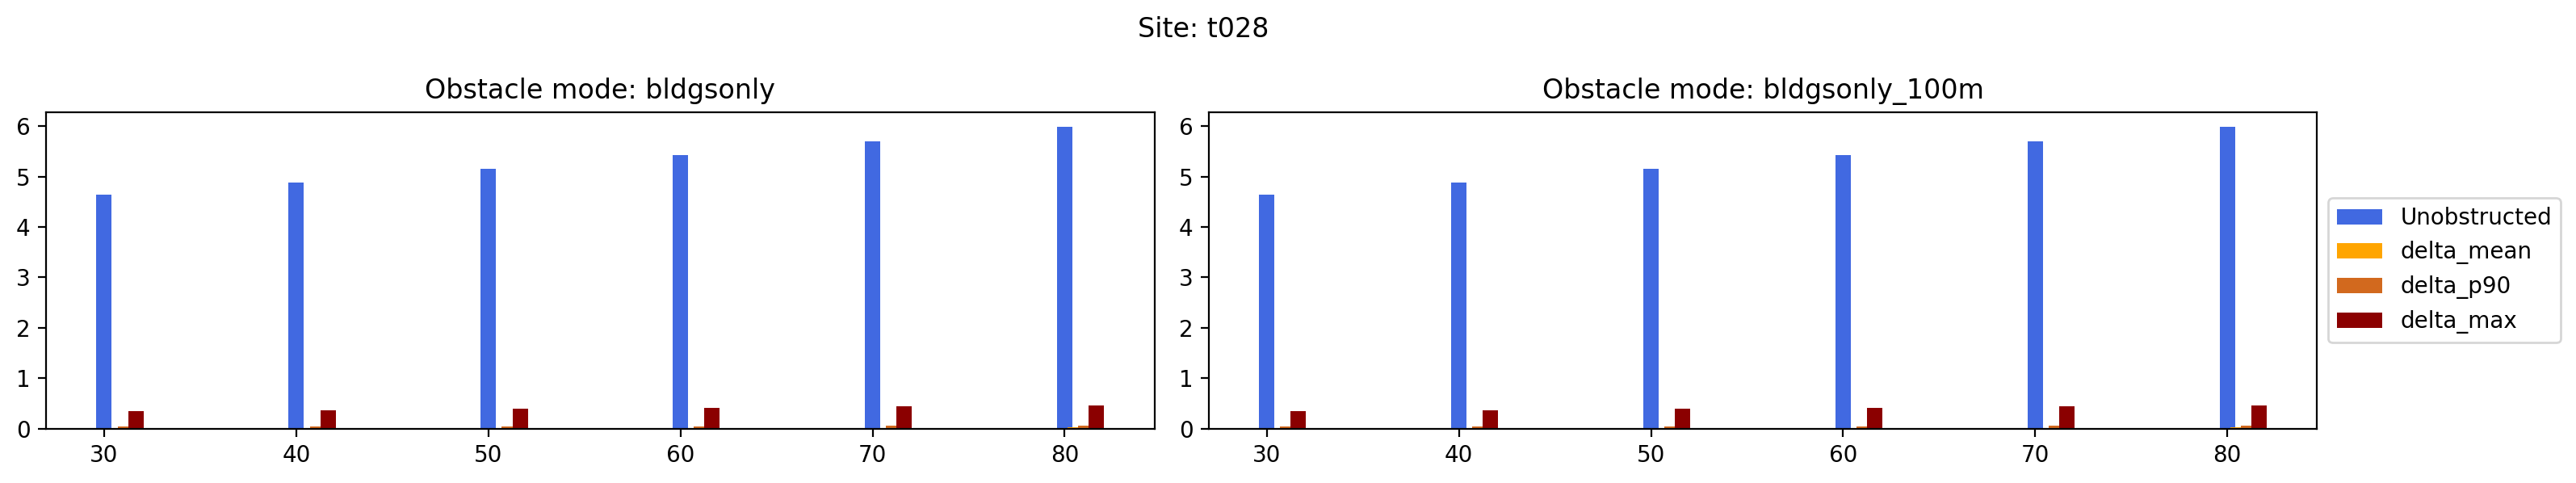

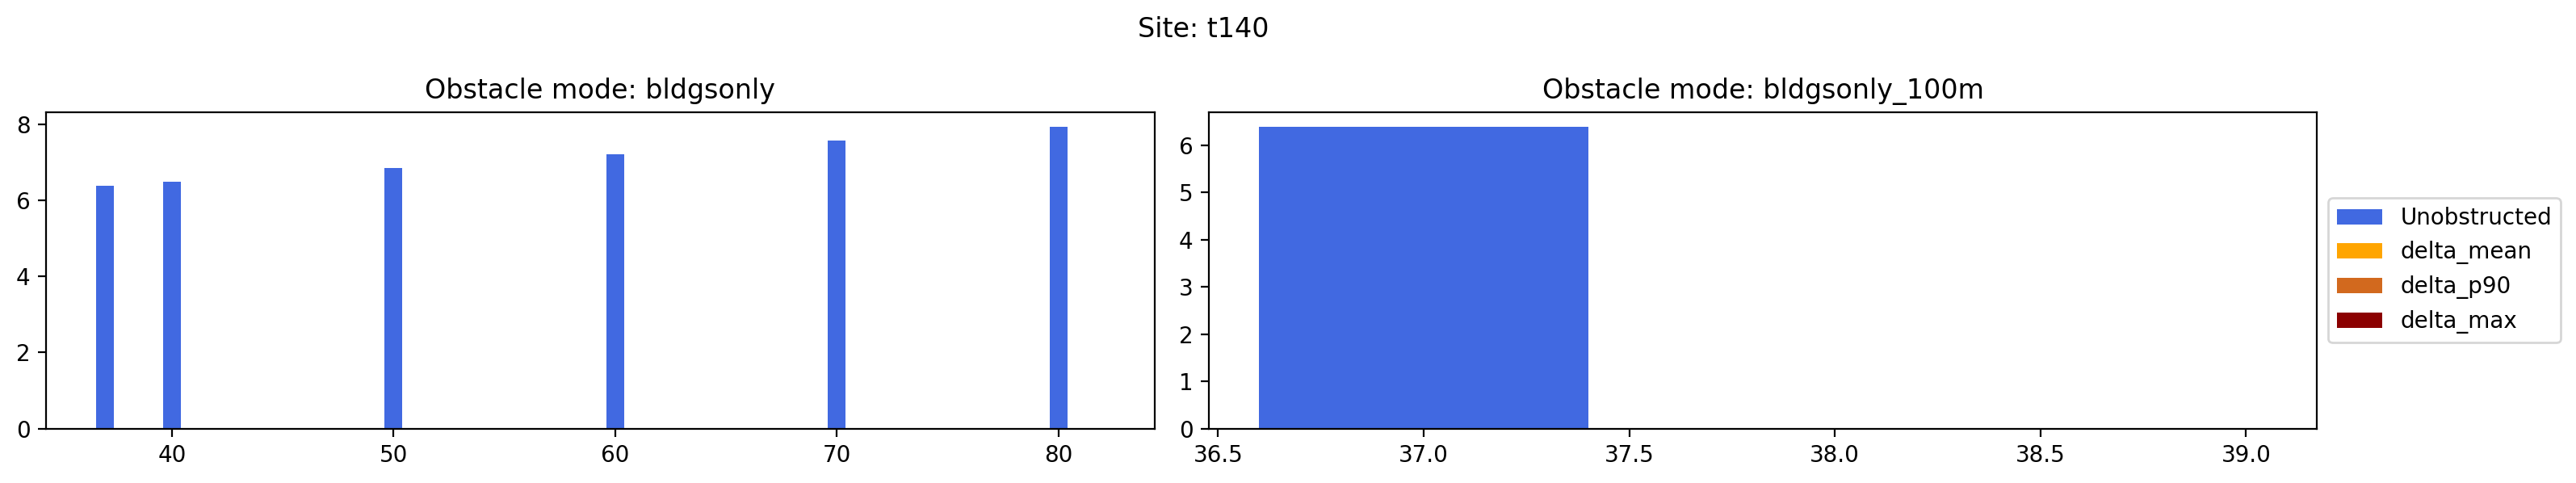

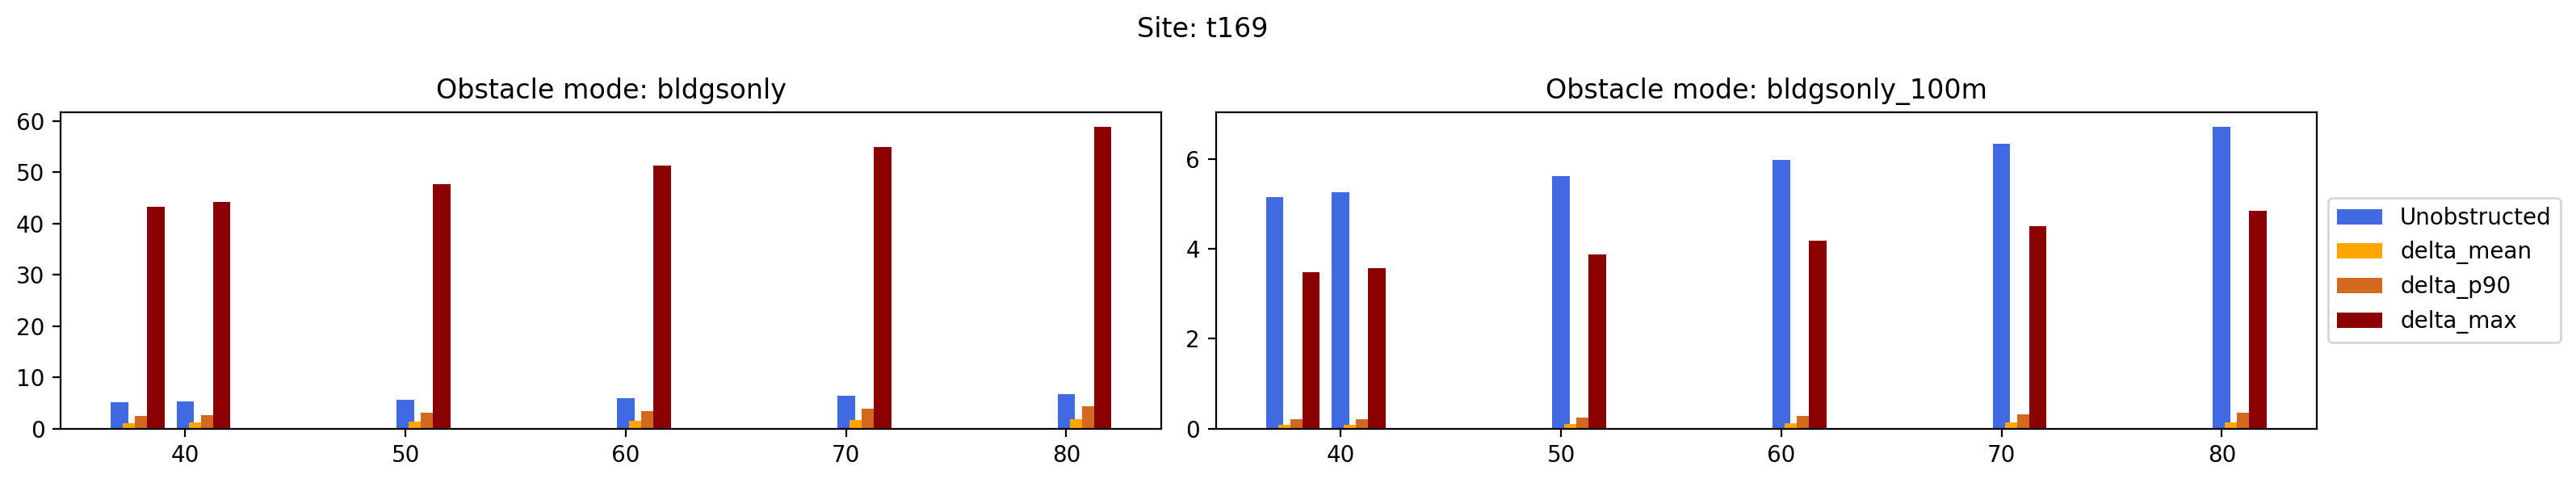

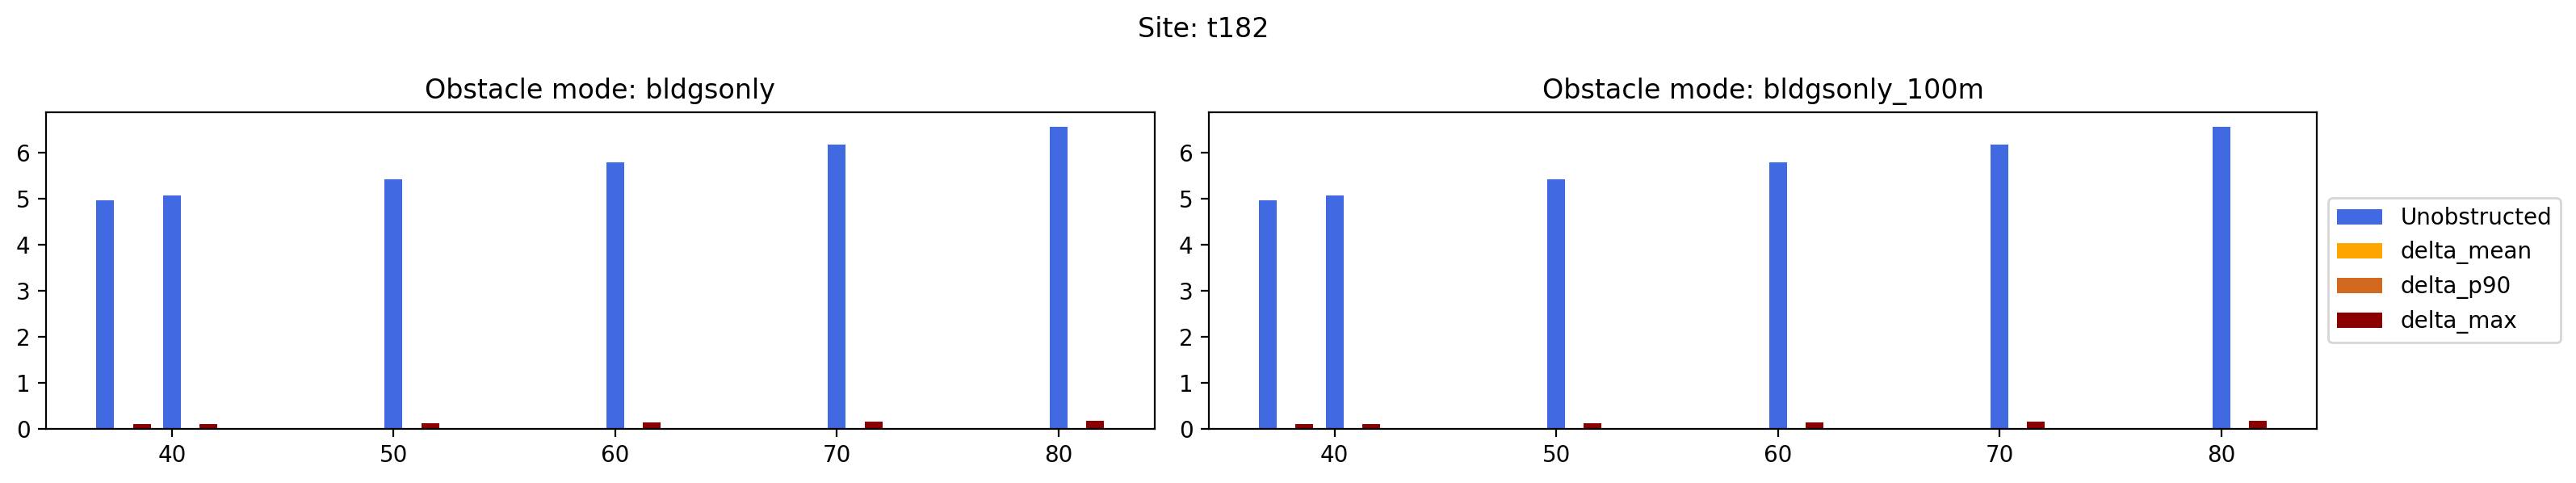

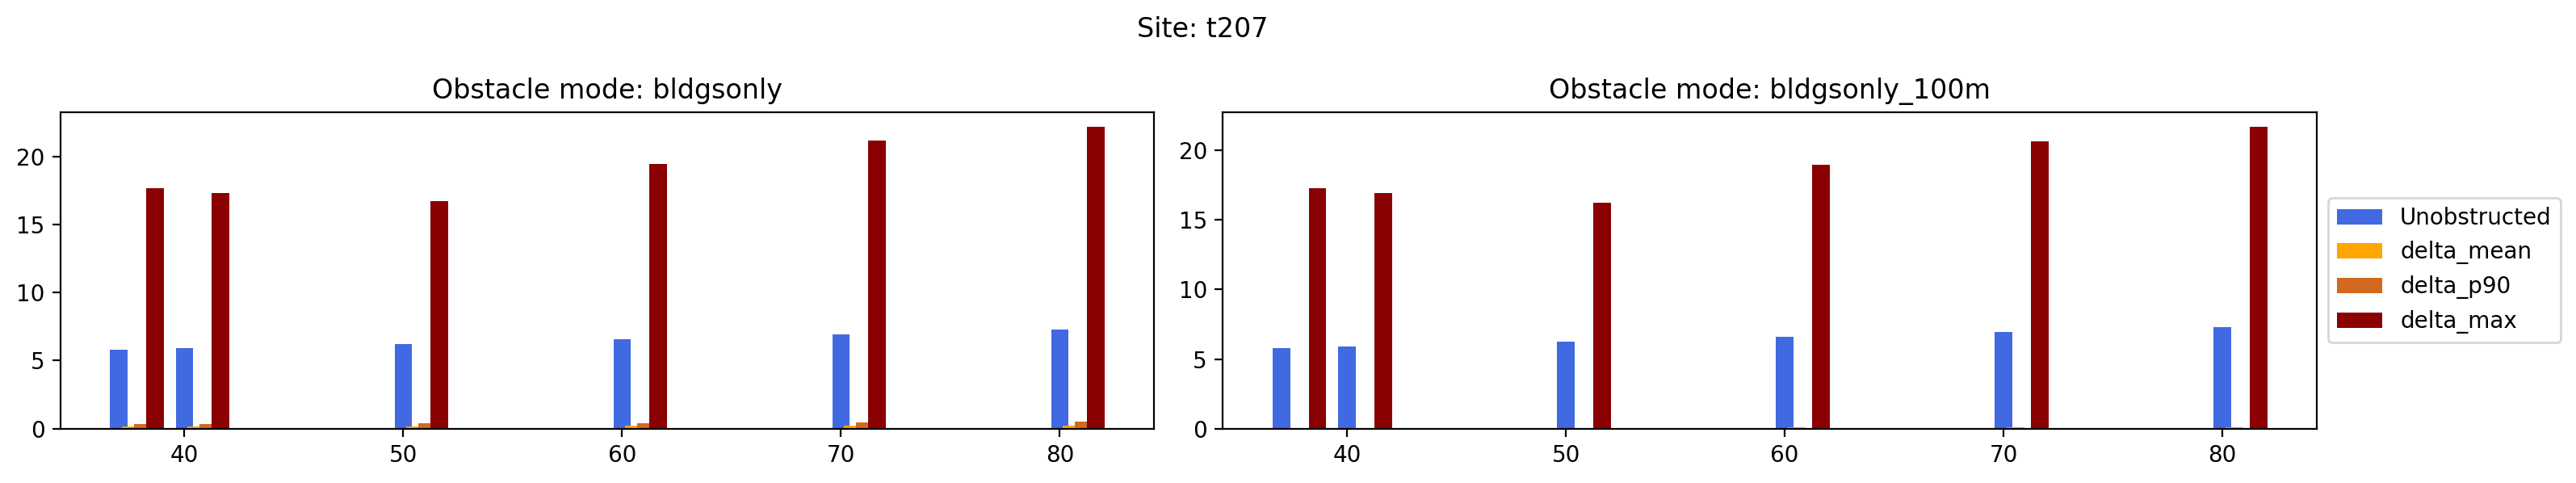

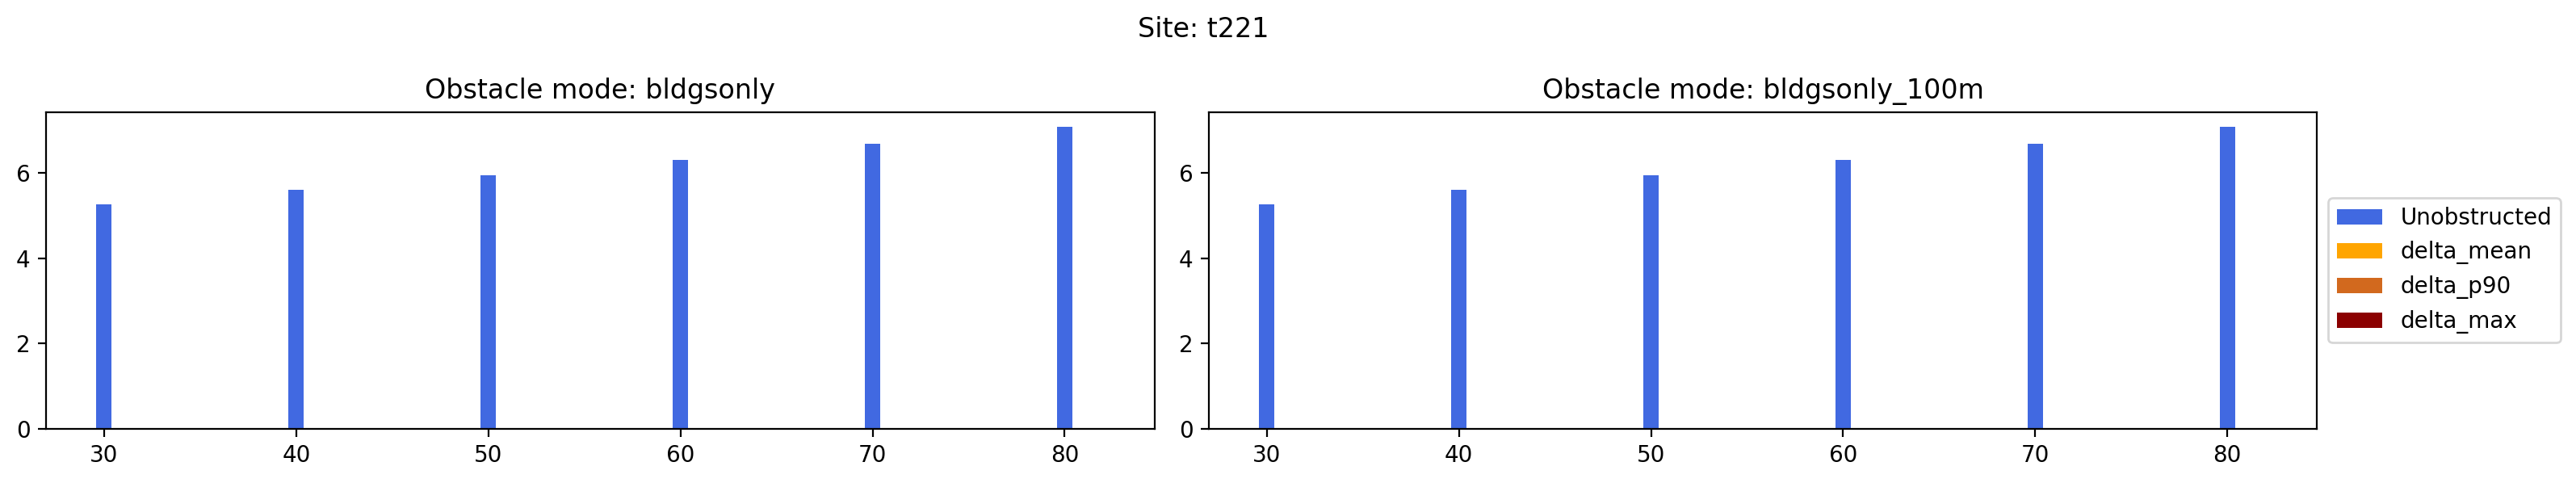

,tid,height,obstacle_mode,mean(ws_adj-ws),max(ws_adj-ws),p90(ws_adj-ws),mean(ws)
7,t221,70,bldgsonly_100m,0.0,0.0,0.0,6.693422
8,t221,60,bldgsonly_100m,0.0,0.0,0.0,6.313760
14,t221,80,bldgsonly,0.0,0.0,0.0,7.077427
16,t221,30,bldgsonly,0.0,0.0,0.0,5.267752
18,t221,40,bldgsonly,0.0,0.0,0.0,5.597366
19,t221,50,bldgsonly,0.0,0.0,0.0,5.942961
46,t221,40,bldgsonly_100m,0.0,0.0,0.0,5.597366
47,t221,50,bldgsonly_100m,0.0,0.0,0.0,5.942961
56,t221,80,bldgsonly_100m,0.0,0.0,0.0,7.077427
63,t221,30,bldgsonly_100m,0.0,0.0,0.0,5.267752


In [174]:
for tid, grp in summary_df.groupby("tid"):
    #print(grp)
    
    if grp.obstacle_mode.nunique() == 2:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,3))
        fig.suptitle("Site: %s" % tid)
        
        bldgsonly_subset = grp[grp["obstacle_mode"] == "bldgsonly"]
        bldgsonly_100m_subset = grp[grp["obstacle_mode"] == "bldgsonly_100m"]
        #print(bldgsonly_subset)
        
        bar_width = 0.55
        
        ax1.bar(bldgsonly_subset.height, bldgsonly_subset["mean(ws)"], color="royalblue")
        ax1.bar(bldgsonly_subset.height+bar_width, bldgsonly_subset["mean(ws_adj-ws)"], color="orange")
        ax1.bar(bldgsonly_subset.height+bar_width*2, bldgsonly_subset["p90(ws_adj-ws)"], color="chocolate")
        ax1.bar(bldgsonly_subset.height+bar_width*3, bldgsonly_subset["max(ws_adj-ws)"], color="darkred")
        ax1.set_title("Obstacle mode: bldgsonly")
        
        ax2.bar(bldgsonly_100m_subset.height, bldgsonly_100m_subset["mean(ws)"], color="royalblue", label="Unobstructed")
        ax2.bar(bldgsonly_100m_subset.height+bar_width, bldgsonly_100m_subset["mean(ws_adj-ws)"],  color="orange", label="delta_mean")
        ax2.bar(bldgsonly_100m_subset.height+bar_width*2, bldgsonly_100m_subset["p90(ws_adj-ws)"], color="chocolate", label="delta_p90")
        ax2.bar(bldgsonly_100m_subset.height+bar_width*3, bldgsonly_100m_subset["max(ws_adj-ws)"], color="darkred", label="delta_max")
        ax2.set_title("Obstacle mode: bldgsonly_100m")
        
        # Shrink current axis by 20%
        box = ax2.get_position()
        ax2.set_position([box.x0, box.y0, box.width * 0.8, box.height])

        # Put a legend to the right of the current axis
        ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
        plt.tight_layout()
        plt.show()
        
        if tid == "t221":
            display(grp)
    elif grp.obstacle_mode.nunique() == 1:
        fig, ax1 = plt.subplots(1, 1, figsize=(7.5,3))
        fig.suptitle("Site: %s" % tid)
        
        bar_width = 0.55
        
        ax1.bar(grp.height, grp["mean(ws)"], color="royalblue", label="Unobstructed")
        ax1.bar(grp.height+bar_width, grp["mean(ws_adj-ws)"], color="orange", label="delta_mean")
        ax1.bar(grp.height+bar_width*2, grp["p90(ws_adj-ws)"], color="chocolate", label="delta_p90")
        ax1.bar(grp.height+bar_width*3, grp["max(ws_adj-ws)"], color="darkred", label="delta_max")
        
        ax1.set_title("Obstacle mode: bldgsonly")
        
        # Shrink current axis by 20%
        box = ax1.get_position()
        ax1.set_position([box.x0, box.y0, box.width * 0.8, box.height])

        # Put a legend to the right of the current axis
        fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
        plt.tight_layout()
        plt.show()
        

bldgsonly         315396
bldgsonly_100m    113893
Name: obstacle_mode, dtype: int64

In [14]:
# Prepare files for PILOWF + multiprocessing & run LOM

# This flag allows overwriting previously saved files with results if they are found in the specified directory dest_dir 
overwrite = True

# Will be used in the filenames
site_type = "bergey"

# Will be used in the filenames
model_type = "anl"

dest_dir = "01 Bergey Turbine Data/pilowf_inputs_rh_analysis/"

script_path = "./run_pilowf_mp.py"

output_dest = "03 Model Outputs/rh_analysis"
if not os.path.exists(output_dest):
    os.makedirs(output_dest)    

for obstacle_mode in obstacle_modes:
    if obstacle_mode == "rh_analysis":
        
        for radius in [100, 200, 300, 400, 500]:

            for wind_source in wind_sources:

                # Make sure to start from scratch and not reuse previously saved inputs for models
                if os.path.exists(dest_dir):
                    shutil.rmtree(dest_dir, ignore_errors=True)
                os.makedirs(dest_dir)    

                for tid in selected:
                    row = index[index["APRS ID"] == tid].iloc[0]
                    #print(row)
                    lat = row["Latitude"]
                    lon = row["Longitude"]
                    z_turbine = row["Hub Height (m)"]
                    xy_turbine = [np.array([lon, lat])]

                    # Assume trees pass the filtering run above in this notebook 
                    obs_df = obstacle_inputs[tid].copy()
                    
                    print("tid=", tid)
                    print("# of obs (before %dm filtering):" % radius, len(obs_df))
                    obs_df = filter_obstacles(tid,
                                              obs_df,
                                              include_trees=True, 
                                              turbine_height_for_checking=z_turbine,
                                              limit_to_radius_in_m=radius,
                                              turbine_lat_lon=(lat, lon))
                    print("# of obs (after %dm filtering):" % radius, len(obs_df))

                    if len(obs_df) == 0:
                        print("tid=%s: Obstacle set is empty after filtering. ws-adjusted=ws for this cases." % tid)

                        output_dest = "%s/%s_%s_%s_%s_%s_%dm.csv.bz2" % (output_dest, site_type, model_type, tid, wind_source, obstacle_mode, radius)

                        if (not overwrite) and (os.path.exists(output_dest)):
                            print("Found previously saved %s); overwrite flag is off. Skipping to next config." % (dest_filename))
                        else:
                            res = atmospheric_inputs[wind_source][tid].copy()
                            res["ws-adjusted"] = res["ws"]
                            res.to_csv(output_dest, index=False)  
                            print("Saved output:", output_dest)

                        # Skip the following and go to the next tid x obstacle_mode combination
                        continue

                    # Save inputs for PILOWF into separate files
                    obs_df.to_file("%s/%s-obstacles.json" % (dest_dir, tid),\
                                   driver="GeoJSON", index=False)
                    atmospheric_inputs[wind_source][tid].to_csv("%s/%s-atmospheric.csv.bz2" % (dest_dir, tid), index=False)

                # It is expecteed that inputs_dir now has a set of individual inputs (atmosperic file and obstacle file for each tid)

                # Must use subprocess as a way of wrapping/calling the python script becuase that script uses multiprocessing
                # and other methods seem to break
                # "<TID>" in "--output_filename_pattern" will replaces with actual TIDs inside the script with parallel processing

                subprocess.run(["python", script_path,
                            "--inputs_dir", dest_dir, \
                            "--index_file", "01 Bergey Turbine Data/bergey_sites.csv", \
                            "--output_filename_pattern", \
                                "%s/%s_%s_%s_%s_%s_%dm.csv.bz2" % (output_dest, site_type, model_type, "<TID>", wind_source, obstacle_mode, radius), \
                            "--procs", "8"],
                           #stdout=subprocess.DEVNULL, # This addition suppresses entire (lengthy) output
                           cwd="./")

tid= t169
# of obs (before 100m filtering): 601
# of obs (after 100m filtering): 5


/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/dw_tap-0.0.1-py3.8.egg/dw_tap/data_processing.py:327: UserWarning: (tid: t169) Detected at least 1 obstacle that is as tall as the studied turbine:
        height feature_type                                           geometry
1    47.690002     building  POLYGON ((-85.12322 41.07841, -85.12321 41.078...
4    38.265015     building  POLYGON ((-85.12048 41.07932, -85.12047 41.079...
5    37.169983     building  POLYGON ((-85.11821 41.07941, -85.11821 41.079...
20   40.309998     building  POLYGON ((-85.11423 41.07398, -85.11421 41.073...
174  59.519958     building  POLYGON ((-85.11854 41.07733, -85.11854 41.077...
176  43.849976     building  POLYGON ((-85.11506 41.07897, -85.11524 41.078...
177  43.159973     building  POLYGON ((-85.11557 41.07895, -85.11575 41.078...
600  40.349976     building  POLYGON ((-85.11578 41.07669, -85.11577 41.076...
  warnings.warn("(tid: %s) Detected at least 1 obstacle that is as tall as 

tid= t221
# of obs (before 100m filtering): 195
# of obs (after 100m filtering): 1


/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' 

tid= t207
# of obs (before 100m filtering): 758
# of obs (after 100m filtering): 2


/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/dw_tap-0.0.1-py3.8.egg/dw_tap/data_processing.py:327: UserWarning: (tid: t207) Detected at least 1 obstacle that is as tall as the studied turbine:
        height feature_type                                           geometry
600  60.192749     building  POLYGON ((-87.71964 41.48273, -87.71967 41.482...
601  41.273163     building  POLYGON ((-87.71890 41.48356, -87.71900 41.483...
614  54.781128     building  POLYGON ((-87.71809 41.48179, -87.71801 41.482...
  warnings.warn("(tid: %s) Detected at least 1 obstacle that is as tall as the studied turbine:\n%s" % \
/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _pr

Done with loading ML model.
Done with loading ML model.
Done with loading ML model.


Runtime: 27.95 (s)
tid= t169
# of obs (before 200m filtering): 601
# of obs (after 200m filtering): 41


/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/dw_tap-0.0.1-py3.8.egg/dw_tap/data_processing.py:327: UserWarning: (tid: t169) Detected at least 1 obstacle that is as tall as the studied turbine:
        height feature_type                                           geometry
1    47.690002     building  POLYGON ((-85.12322 41.07841, -85.12321 41.078...
4    38.265015     building  POLYGON ((-85.12048 41.07932, -85.12047 41.079...
5    37.169983     building  POLYGON ((-85.11821 41.07941, -85.11821 41.079...
20   40.309998     building  POLYGON ((-85.11423 41.07398, -85.11421 41.073...
174  59.519958     building  POLYGON ((-85.11854 41.07733, -85.11854 41.077...
176  43.849976     building  POLYGON ((-85.11506 41.07897, -85.11524 41.078...
177  43.159973     building  POLYGON ((-85.11557 41.07895, -85.11575 41.078...
600  40.349976     building  POLYGON ((-85.11578 41.07669, -85.11577 41.076...
  warnings.warn("(tid: %s) Detected at least 1 obstacle that is as tall as 

tid= t221
# of obs (before 200m filtering): 195
# of obs (after 200m filtering): 3


/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' 

tid= t207
# of obs (before 200m filtering): 758
# of obs (after 200m filtering): 14


/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/dw_tap-0.0.1-py3.8.egg/dw_tap/data_processing.py:327: UserWarning: (tid: t207) Detected at least 1 obstacle that is as tall as the studied turbine:
        height feature_type                                           geometry
600  60.192749     building  POLYGON ((-87.71964 41.48273, -87.71967 41.482...
601  41.273163     building  POLYGON ((-87.71890 41.48356, -87.71900 41.483...
614  54.781128     building  POLYGON ((-87.71809 41.48179, -87.71801 41.482...
  warnings.warn("(tid: %s) Detected at least 1 obstacle that is as tall as the studied turbine:\n%s" % \
/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _pr

Done with loading ML model.
Done with loading ML model.
Done with loading ML model.


Runtime: 148.79 (s)
tid= t169
# of obs (before 300m filtering): 601
# of obs (after 300m filtering): 91


/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/dw_tap-0.0.1-py3.8.egg/dw_tap/data_processing.py:327: UserWarning: (tid: t169) Detected at least 1 obstacle that is as tall as the studied turbine:
        height feature_type                                           geometry
1    47.690002     building  POLYGON ((-85.12322 41.07841, -85.12321 41.078...
4    38.265015     building  POLYGON ((-85.12048 41.07932, -85.12047 41.079...
5    37.169983     building  POLYGON ((-85.11821 41.07941, -85.11821 41.079...
20   40.309998     building  POLYGON ((-85.11423 41.07398, -85.11421 41.073...
174  59.519958     building  POLYGON ((-85.11854 41.07733, -85.11854 41.077...
176  43.849976     building  POLYGON ((-85.11506 41.07897, -85.11524 41.078...
177  43.159973     building  POLYGON ((-85.11557 41.07895, -85.11575 41.078...
600  40.349976     building  POLYGON ((-85.11578 41.07669, -85.11577 41.076...
  warnings.warn("(tid: %s) Detected at least 1 obstacle that is as tall as 

tid= t221
# of obs (before 300m filtering): 195
# of obs (after 300m filtering): 4


/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' 

tid= t207
# of obs (before 300m filtering): 758
# of obs (after 300m filtering): 60


/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/dw_tap-0.0.1-py3.8.egg/dw_tap/data_processing.py:327: UserWarning: (tid: t207) Detected at least 1 obstacle that is as tall as the studied turbine:
        height feature_type                                           geometry
600  60.192749     building  POLYGON ((-87.71964 41.48273, -87.71967 41.482...
601  41.273163     building  POLYGON ((-87.71890 41.48356, -87.71900 41.483...
614  54.781128     building  POLYGON ((-87.71809 41.48179, -87.71801 41.482...
  warnings.warn("(tid: %s) Detected at least 1 obstacle that is as tall as the studied turbine:\n%s" % \
/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _pr

Done with loading ML model.
Done with loading ML model.
Done with loading ML model.


Runtime: 318.42 (s)
tid= t169
# of obs (before 400m filtering): 601
# of obs (after 400m filtering): 158


/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/dw_tap-0.0.1-py3.8.egg/dw_tap/data_processing.py:327: UserWarning: (tid: t169) Detected at least 1 obstacle that is as tall as the studied turbine:
        height feature_type                                           geometry
1    47.690002     building  POLYGON ((-85.12322 41.07841, -85.12321 41.078...
4    38.265015     building  POLYGON ((-85.12048 41.07932, -85.12047 41.079...
5    37.169983     building  POLYGON ((-85.11821 41.07941, -85.11821 41.079...
20   40.309998     building  POLYGON ((-85.11423 41.07398, -85.11421 41.073...
174  59.519958     building  POLYGON ((-85.11854 41.07733, -85.11854 41.077...
176  43.849976     building  POLYGON ((-85.11506 41.07897, -85.11524 41.078...
177  43.159973     building  POLYGON ((-85.11557 41.07895, -85.11575 41.078...
600  40.349976     building  POLYGON ((-85.11578 41.07669, -85.11577 41.076...
  warnings.warn("(tid: %s) Detected at least 1 obstacle that is as tall as 

tid= t221
# of obs (before 400m filtering): 195
# of obs (after 400m filtering): 20


/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' 

tid= t207
# of obs (before 400m filtering): 758
# of obs (after 400m filtering): 150


/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/dw_tap-0.0.1-py3.8.egg/dw_tap/data_processing.py:327: UserWarning: (tid: t207) Detected at least 1 obstacle that is as tall as the studied turbine:
        height feature_type                                           geometry
600  60.192749     building  POLYGON ((-87.71964 41.48273, -87.71967 41.482...
601  41.273163     building  POLYGON ((-87.71890 41.48356, -87.71900 41.483...
614  54.781128     building  POLYGON ((-87.71809 41.48179, -87.71801 41.482...
  warnings.warn("(tid: %s) Detected at least 1 obstacle that is as tall as the studied turbine:\n%s" % \
/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _pr

Done with loading ML model.
Done with loading ML model.
Done with loading ML model.


Runtime: 950.91 (s)
tid= t169
# of obs (before 500m filtering): 601


/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/dw_tap-0.0.1-py3.8.egg/dw_tap/data_processing.py:327: UserWarning: (tid: t169) Detected at least 1 obstacle that is as tall as the studied turbine:
        height feature_type                                           geometry
1    47.690002     building  POLYGON ((-85.12322 41.07841, -85.12321 41.078...
4    38.265015     building  POLYGON ((-85.12048 41.07932, -85.12047 41.079...
5    37.169983     building  POLYGON ((-85.11821 41.07941, -85.11821 41.079...
20   40.309998     building  POLYGON ((-85.11423 41.07398, -85.11421 41.073...
174  59.519958     building  POLYGON ((-85.11854 41.07733, -85.11854 41.077...
176  43.849976     building  POLYGON ((-85.11506 41.07897, -85.11524 41.078...
177  43.159973     building  POLYGON ((-85.11557 41.07895, -85.11575 41.078...
600  40.349976     building  POLYGON ((-85.11578 41.07669, -85.11577 41.076...
  warnings.warn("(tid: %s) Detected at least 1 obstacle that is as tall as 

# of obs (after 500m filtering): 252
tid= t221
# of obs (before 500m filtering): 195
# of obs (after 500m filtering): 43


/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' 

tid= t207
# of obs (before 500m filtering): 758
# of obs (after 500m filtering): 277


/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/dw_tap-0.0.1-py3.8.egg/dw_tap/data_processing.py:327: UserWarning: (tid: t207) Detected at least 1 obstacle that is as tall as the studied turbine:
        height feature_type                                           geometry
600  60.192749     building  POLYGON ((-87.71964 41.48273, -87.71967 41.482...
601  41.273163     building  POLYGON ((-87.71890 41.48356, -87.71900 41.483...
614  54.781128     building  POLYGON ((-87.71809 41.48179, -87.71801 41.482...
  warnings.warn("(tid: %s) Detected at least 1 obstacle that is as tall as the studied turbine:\n%s" % \
/Users/dduplyak/anaconda3/envs/dw-tap/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _pr

Done with loading ML model.
Done with loading ML model.
Done with loading ML model.


Runtime: 1030.74 (s)


In [ ]:
# Check one case and confirm that there is indeed difference between
# bldgsonly and bldgsandtrees

# f1 = "03 Model Outputs/bergey_anl_t034_wtk_bc_bldgsonly.csv.bz2"
# df1 = pd.read_csv(f1)
# df1

# f2 = "03 Model Outputs/bergey_anl_t034_wtk_bc_bldgsandtrees.csv.bz2"
# df2 = pd.read_csv(f2)
# df2

# Looking for non-zero mean here to see the difference between two outputs
# (df2["ws-adjusted"] - df1["ws-adjusted"]).mean()

In [ ]:
# Quick vis of data in produced files

# for f in glob.iglob("%s/*" % dest_dir):
#     df = pd.read_csv(f)
#     fig = plt.gcf()
#     fig.set_size_inches(2.5,2.5)
#     sns.scatterplot(x=df["ws"], \
#                     y=df["ws-adjusted"], alpha=0.2).set(title=os.path.basename(f));
#     plt.show()

### Analysis of saved results

In [15]:
import glob
import os
import pandas as pd
output_dest = "03 Model Outputs/rh_analysis"

combined = [] 
for f in glob.glob("%s/*" % output_dest):
    tid = os.path.basename(f).split("_")[2]
    radius = os.path.basename(f).split("_")[-1].split(".")[0].replace("m", "")
    df = pd.read_csv(f)
    df["tid"] = tid
    df["radius"] = radius
    combined.append(df)
    
combined_df = pd.concat(combined)
combined_df

,datetime,ws,wd,inversemoninobukhovlength_2m,tid,packet_date,ws-adjusted,radius
0,2007-01-01 00:00:00,9.310379,206.091850,0.004875,t169,2007-01-01 00:00:00+00:00,10.646612,200
1,2007-01-01 01:00:00,7.469458,204.827926,0.018617,t169,2007-01-01 01:00:00+00:00,8.253932,200
2,2007-01-01 02:00:00,7.788576,215.592004,0.013519,t169,2007-01-01 02:00:00+00:00,8.760720,200
3,2007-01-01 03:00:00,8.219434,223.464590,0.013858,t169,2007-01-01 03:00:00+00:00,9.377820,200
4,2007-01-01 04:00:00,8.166738,218.856029,0.012964,t169,2007-01-01 04:00:00+00:00,9.230800,200
...,...,...,...,...,...,...,...,...
61363,2013-12-31 19:00:00,3.531087,250.045036,-0.063679,t207,2013-12-31 19:00:00+00:00,3.563279,500
61364,2013-12-31 20:00:00,2.754635,256.581729,-0.062164,t207,2013-12-31 20:00:00+00:00,2.771522,500
61365,2013-12-31 21:00:00,2.789364,248.176577,-0.032253,t207,2013-12-31 21:00:00+00:00,2.810019,500
61366,2013-12-31 22:00:00,1.833750,264.252717,-0.040186,t207,2013-12-31 22:00:00+00:00,1.841256,500


In [16]:
from sklearn.metrics import mean_squared_error 
#rmse = mean_squared_error(realVals, predictedVals, squared = False)

summary_df = pd.DataFrame(columns=["tid", "radius", "rmse"])
for tid, tid_grp in combined_df.groupby("tid"):
    for radius, radius_grp in tid_grp.groupby("radius"):
        
        rmse = mean_squared_error(radius_grp["ws"], radius_grp["ws-adjusted"], squared=False)
        #print(tid, radius, rmse)
        summary_df.loc[len(summary_df)] = [tid, radius, rmse]
        
display(summary_df)

,tid,radius,rmse
0,t169,100,0.217517
1,t169,200,1.744901
2,t169,300,1.969714
3,t169,400,2.141153
4,t169,500,2.217626
5,t207,100,0.361047
6,t207,200,0.372401
7,t207,300,0.394495
8,t207,400,0.402500
9,t207,500,0.408344


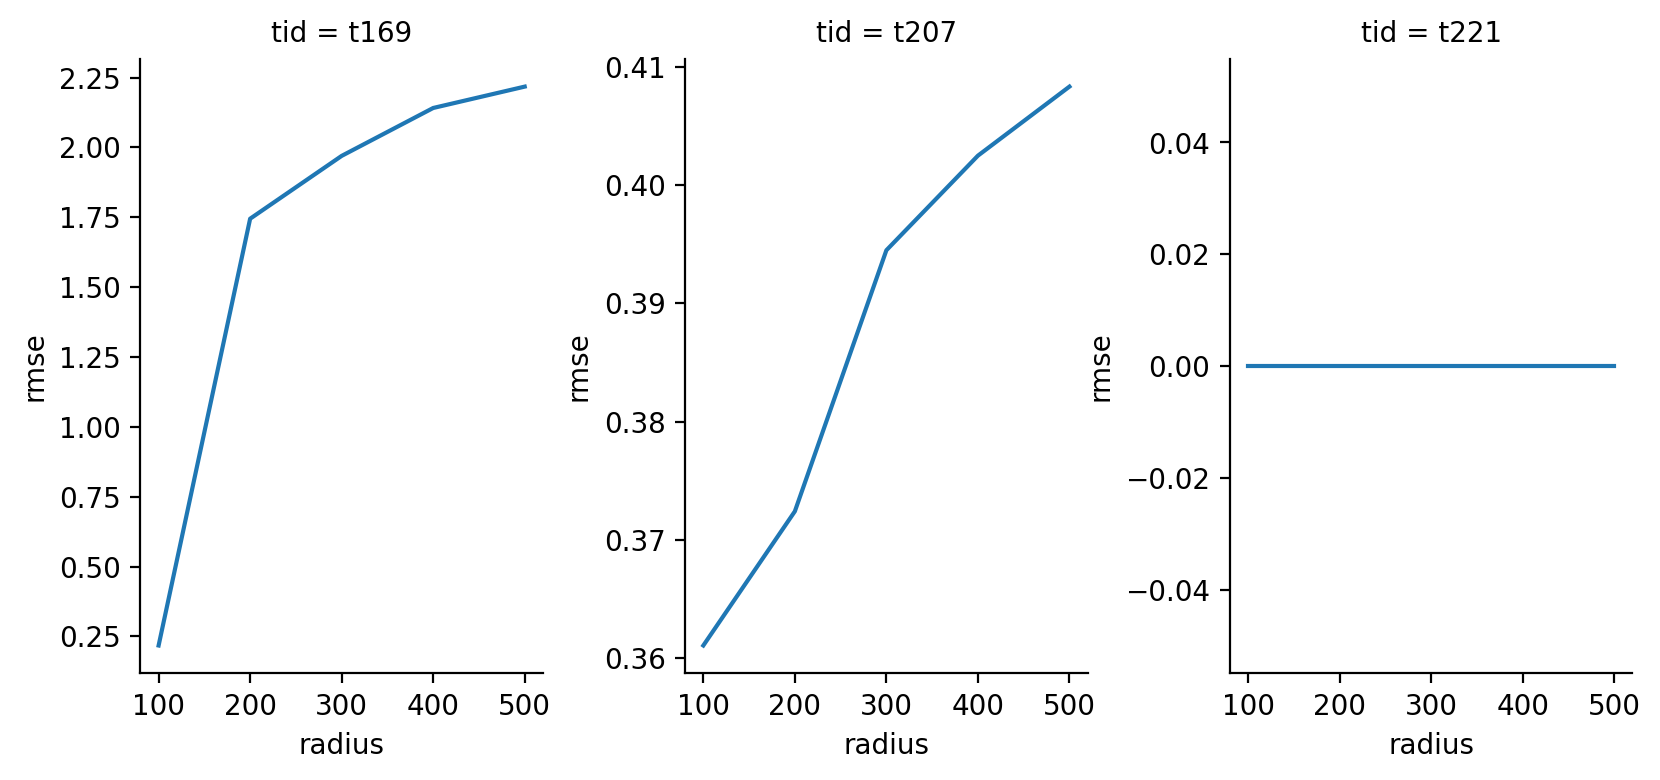

In [18]:
import seaborn as sns
sns.relplot(
    data=summary_df,
    x="radius", y="rmse",
    col="tid",
    kind="line",
    height=4, aspect=0.7, facet_kws=dict(sharex=False, sharey=False),
)